# Topical Expert Model

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import os
print(os.getcwd())
print(os.listdir('/Users/Brandon/Yelp Dataset/dataset'))
import json
import glob
from datetime import datetime
from pandas import HDFStore,DataFrame
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

/Users/Brandon/Yelp Dataset/Yelp-FA17/local-elites/brandon
['.DS_Store', 'business.json', 'checkin.json', 'photos.json', 'review.json', 'review5000.json', 'tip.json', 'user.json', 'user5000.json']


In [2]:
#Copied from Kenta
def load_json_to_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

LOAD THE DATA

In [3]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/review.json"
review = load_json_to_df(import_file)

CPU times: user 1min 3s, sys: 19.9 s, total: 1min 23s
Wall time: 1min 32s


In [4]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/business.json"
business = load_json_to_df(import_file)

CPU times: user 5.14 s, sys: 411 ms, total: 5.55 s
Wall time: 5.72 s


In [5]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/user.json"
user = load_json_to_df(import_file)

CPU times: user 53.5 s, sys: 16.2 s, total: 1min 9s
Wall time: 1min 18s


Sort by category

In [6]:
def categoryFind(df, cat):
    return [cat in i for i in df['categories']]

def category_counts(df):
    all_cats = []
    for i in df['categories']:
        for j in i:
            all_cats.append(j)
    categories = set(all_cats)
    category_counts = {}
    for cat in categories:
        category_counts[cat] = all_cats.count(cat)
    return len(categories), category_counts

def top_categories(counts, n):
    top_categories = sorted(counts.keys(), key=(lambda k: counts[k]),reverse=True)[:n]
    return top_categories

In [7]:
num_cats, cat_counts = category_counts(business)
top_cats = top_categories(cat_counts, 15)
display(top_cats)

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food']

In [10]:
%%time
businessReviews = pd.merge(review, business,on='business_id',right_index=True,sort=False)[['business_id', 'cool', 'funny', 'review_id', 'stars_x', 'text', 'useful', 'user_id', 'categories', 'review_count', 'stars_y']]
bus_rev_users = pd.merge(businessReviews, user,on='user_id',right_index=True,sort=False)[['business_id', 'cool_x', 'funny_x', 'review_id', 'stars_x', 'text', 'useful_x', 'user_id', 'categories', 'stars_y', 'average_stars', 'cool_y', 'elite', 'fans', 'friends', 'name', 'review_count_y', 'yelping_since']]

CPU times: user 57.6 s, sys: 29.3 s, total: 1min 26s
Wall time: 1min 48s


In [11]:
display(len(businessReviews))
display(len(bus_rev_users))
display(list(businessReviews))
display(list(bus_rev_users))

4736897

4736897

['business_id',
 'cool',
 'funny',
 'review_id',
 'stars_x',
 'text',
 'useful',
 'user_id',
 'categories',
 'review_count',
 'stars_y']

['business_id',
 'cool_x',
 'funny_x',
 'review_id',
 'stars_x',
 'text',
 'useful_x',
 'user_id',
 'categories',
 'stars_y',
 'average_stars',
 'cool_y',
 'elite',
 'fans',
 'friends',
 'name',
 'review_count_y',
 'yelping_since']

## Feature Extraction From Yelp Data

In [12]:
def category_choose(df, categories):
    cats = np.array([True] * len(df['categories']))
    for cat in categories:
        cats= cats & np.array(categoryFind(df,cat))
    return df[cats]

def numCategoryReviews(businessReviews):
    return businessReviews[['business_id','user_id']].groupby('user_id',as_index=False).count()

def average_star_category_rating(businessReviews):
    return businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).mean()

def std_star_category_rating(businessReviews):
    busRev = businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).agg(np.var)
    busRev['stars_x'] = busRev['stars_x'].pow(1./2)
    return busRev

def funny_useful_cool(businessReviews):
    return businessReviews[['user_id','funny','useful','cool']].groupby('user_id',as_index=False).sum()

def months_yelping(businessReviews):
    user_dates = businessReviews[['user_id','yelping_since']].drop_duplicates()
    curr_date = datetime(2017,10,17)
    uyelp_dates = [datetime.strptime(i, "%Y-%m-%d") for i in user_dates['yelping_since']]
    months_yelping = [(curr_date.year - i.year) * 12 + curr_date.month - i.month for i in uyelp_dates]
    user_dates['yelping_since'] = months_yelping
    return user_dates

def get_elite_users(df):
    temp = []
    for i in df['elite'].index.values:
        if df['elite'][i]:
            temp.append(i)
    return temp, df.loc[temp]

## Define the first feature model to be analyzed
Features: Total Reviews by User, Number of Category Reviews, Average Rating in Category, Std Dev of Ratings in Category, Funny, Useful, and Cool Votes, Number of Months since joining Yelp.

In [13]:
def feature1(df, df1, categories):
    if( not categories == "All"):
        df = category_choose(df, categories)
        df1 = category_choose(df1, categories)
    tot_reviews = df1[['user_id','review_count_y']]
    tot_reviews.columns = ['user_id','Total Reviews by User']
    catRev = numCategoryReviews(df)
    catRev.columns = ['user_id','Num Category Reviews']
    averageCat = average_star_category_rating(df)
    averageCat.columns = ['user_id','Average Rating in Category']
    stdCat = std_star_category_rating(df)
    stdCat.columns = ['user_id','Std Dev of Ratings in Category']
    fuc = funny_useful_cool(df)
    monthsYelp = months_yelping(df1)
    monthsYelp.columns = ['user_id', 'Months Yelping']
    is_elite = df1[['user_id','elite']]
    features = tot_reviews.merge(catRev,on='user_id').merge(averageCat,on='user_id').merge(stdCat,on='user_id').merge(fuc,on='user_id').merge(monthsYelp,on='user_id').merge(is_elite,on='user_id')
    features = features.drop_duplicates('user_id')
    features.index = range(len(features))
    elite_ind, elite_users = get_elite_users(features)
    expertClassifier = [0]*len(features)
    for i in elite_ind:
        expertClassifier[i]=1
    features = pd.concat([features, pd.DataFrame(expertClassifier,columns=['is_expert'])],axis=1)
    return features.fillna(0)

# Feature 2 has all of feature 1 plus the number of friends for each user
def feature2(df, df1, categories, features1 = pd.DataFrame()):
    if features1.empty:
        features1= feature1(df,df1,categories)
    
    friends = pd.DataFrame([len(i) for i in df1['friends']], columns = ['Num_Friends'])
    users = pd.DataFrame(df1['user_id'].values,columns=['user_id'])
    num_friends = pd.concat([users, friends],axis=1)
    features1= features1.merge(num_friends,on='user_id').drop_duplicates('user_id')
    features1.index = range(len(features1))
    return features1
    

In [14]:
%%time
# Lets do places with categories Chinese Restaurant
categories = ['Restaurants','Chinese']
feature_set_1 = feature1(businessReviews, bus_rev_users, categories)

CPU times: user 14 s, sys: 8.04 s, total: 22 s
Wall time: 27.1 s


In [15]:
feature_set_2 = feature2(businessReviews, bus_rev_users, categories, feature_set_1)
feature_set_2

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert,Num_Friends
0,zXnH6W74FAJQ7q7b-NuBsA,90,1,4.000000,0.000000,0,0,0,87,[],0,26
1,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,2,0,68,"[2013, 2014]",1,15
2,kzyLOqiJvyw_FWFTw2rjiQ,2,1,1.000000,0.000000,0,0,0,16,[],0,0
3,WZXp9-V2dqRRJqhGgRqueA,327,4,2.500000,1.000000,4,6,4,61,"[2016, 2015]",1,181
4,XylT12exfdLiI_3uDLVIpw,344,1,5.000000,0.000000,1,2,1,84,[],0,762
5,Ji9PeffxjwqPLO7pEfSpKQ,93,6,2.500000,1.048809,6,9,7,107,"[2010, 2009]",1,53
6,TLIWzAJPrET0zX4_vgvLhg,53,1,3.000000,0.000000,0,0,0,38,[],0,19
7,JZEiTNWBwmv6MOOXYCAaMQ,5,2,1.000000,0.000000,0,0,0,29,[],0,0
8,E56sVQT5-OWfSejJrma8_w,13,1,5.000000,0.000000,1,1,1,68,[],0,19
9,4WYICo4emecA9r7sPYQkBw,15,1,4.000000,0.000000,0,0,0,99,[],0,0


In [16]:
display(len(feature_set_1))
display(feature_set_1.head(5))

109685

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert
0,zXnH6W74FAJQ7q7b-NuBsA,90,1,4.0,0.0,0,0,0,87,[],0
1,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.0,0.0,0,2,0,68,"[2013, 2014]",1
2,kzyLOqiJvyw_FWFTw2rjiQ,2,1,1.0,0.0,0,0,0,16,[],0
3,WZXp9-V2dqRRJqhGgRqueA,327,4,2.5,1.0,4,6,4,61,"[2016, 2015]",1
4,XylT12exfdLiI_3uDLVIpw,344,1,5.0,0.0,1,2,1,84,[],0


## Classifier Setups (Sklearn Library)*

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

In [18]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives the classifications'''
def run_model(clf, features):
    train, test = train_test_split(X)
    train_classifier = train['is_expert'].values
    test_classifier = test['is_expert'].values
    train = train.drop('is_expert',axis=1)
    test = test.drop('is_expert', axis=1)
    clf.fit(train, train_classifier)
    rf_pred = clf.predict(test)
    model_perf= {'Model_Score' : clf.score(test, test_classifier),
                'Predictions' : rf_pred,
                'Actual' : test_classifier,
                'Prediction_Probabilities' : clf.predict_proba(test),
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Experts_Actual' : sum(test_classifier),
                'Num_Experts_Training' : sum(train_classifier)} 
    return model_perf

'''Runs the model n times, and prints out a dictionary with the statistics'''
def bootstrap_model(clf, features, n):
    models = []
    for i in range(1,n):
        models.append(run_model(clf, features))
    return models

'''Gets statistics from the bootstrap list of dictionaries'''
def boot_statistics(models):
    stats = []
    mean_model_score = np.mean([i['Model_Score'] for i in models])
    expert_pred_percentage = [i['Num_Experts_Predicted']/i['Num_Experts_Actual'] for i in models]
    mn = np.array((1.0 - np.array(mean_model_score))) * np.array(models[0]['Total_Tested'])
    stats = {'Mean_Wrong_Predictions' : round(mn),
             'Mean_Model_Score' : mean_model_score, 
             'Expert_Prediction_Percentage' : expert_pred_percentage}
    return stats

def graph_from_statistics(stats):
    return 0

 #### Drop unnessary columns from the features table (call it X).

In [19]:
X = feature_set_1.drop('user_id',axis=1).drop('elite',axis=1)
X2 = feature_set_2.drop('user_id',axis=1).drop('elite',axis=1)

## Run a random forest classifier

In [20]:
clf_RF = RandomForestClassifier(max_depth=3)

display(run_model(clf_RF,X))
display(run_model(clf_RF,X2))

RF_bootstrap = bootstrap_model(clf_RF, X, 10)
RF2_bootstrap = bootstrap_model(clf_RF, X2, 10)

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.90117423966158561,
 'Num_Experts_Actual': 3577,
 'Num_Experts_Predicted': 1407,
 'Num_Experts_Training': 10793,
 'Prediction_Probabilities': array([[ 0.90946516,  0.09053484],
        [ 0.95673153,  0.04326847],
        [ 0.93058782,  0.06941218],
        ..., 
        [ 0.96179432,  0.03820568],
        [ 0.95673153,  0.04326847],
        [ 0.95673153,  0.04326847]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 27422}

{'Actual': array([0, 0, 1, ..., 0, 1, 0]),
 'Model_Score': 0.90197651520676825,
 'Num_Experts_Actual': 3535,
 'Num_Experts_Predicted': 1447,
 'Num_Experts_Training': 10835,
 'Prediction_Probabilities': array([[ 0.78467969,  0.21532031],
        [ 0.66321911,  0.33678089],
        [ 0.45990758,  0.54009242],
        ..., 
        [ 0.93787107,  0.06212893],
        [ 0.65288119,  0.34711881],
        [ 0.95636642,  0.04363358]]),
 'Predictions': array([0, 0, 1, ..., 0, 0, 0]),
 'Total_Tested': 27422}

## Run a gaussian naive bayes classifier

In [21]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()

display(run_model(clf_NB,X))
display(run_model(clf_NB,X2))

NB_bootstrap = bootstrap_model(clf_NB, X, 10)
NB2_bootstrap = bootstrap_model(clf_NB, X2, 10)

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.90755597695281165,
 'Num_Experts_Actual': 3558,
 'Num_Experts_Predicted': 2157,
 'Num_Experts_Training': 10812,
 'Prediction_Probabilities': array([[  9.99997865e-01,   2.13489568e-06],
        [  9.99999462e-01,   5.37784118e-07],
        [  9.99999566e-01,   4.33810304e-07],
        ..., 
        [  9.99998685e-01,   1.31491193e-06],
        [  9.99997302e-01,   2.69763170e-06],
        [  9.99999505e-01,   4.94898960e-07]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 27422}

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.9070089708992779,
 'Num_Experts_Actual': 3596,
 'Num_Experts_Predicted': 2214,
 'Num_Experts_Training': 10774,
 'Prediction_Probabilities': array([[  9.99993213e-01,   6.78686689e-06],
        [  3.01618782e-10,   1.00000000e+00],
        [  9.99998534e-01,   1.46648544e-06],
        ..., 
        [  9.99998971e-01,   1.02947679e-06],
        [  9.99998274e-01,   1.72643909e-06],
        [  9.99998055e-01,   1.94530498e-06]]),
 'Predictions': array([0, 1, 0, ..., 0, 0, 0]),
 'Total_Tested': 27422}

## Run a decision tree classifier

In [22]:
clf_DT = tree.DecisionTreeClassifier()

display(run_model(clf_DT, X))
display(run_model(clf_DT, X2))

DT_bootstrap = bootstrap_model(clf_DT, X, 10)
DT2_bootstrap = bootstrap_model(clf_DT, X2, 10)

{'Actual': array([0, 0, 0, ..., 0, 0, 1]),
 'Model_Score': 0.9036540004376048,
 'Num_Experts_Actual': 3624,
 'Num_Experts_Predicted': 3654,
 'Num_Experts_Training': 10746,
 'Prediction_Probabilities': array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 1]),
 'Total_Tested': 27422}

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.90547735394938367,
 'Num_Experts_Actual': 3610,
 'Num_Experts_Predicted': 3546,
 'Num_Experts_Training': 10760,
 'Prediction_Probabilities': array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 27422}

In [23]:
DT_stats = boot_statistics(DT_bootstrap)
NB_stats = boot_statistics(NB_bootstrap)
RF_stats = boot_statistics(RF_bootstrap)
#
DT2_stats = boot_statistics(DT2_bootstrap)
NB2_stats = boot_statistics(NB2_bootstrap)
RF2_stats = boot_statistics(RF2_bootstrap)

display(DT_stats, DT2_stats)
display(NB_stats, DT2_stats)
display(RF_stats, RF2_stats)
y = [DT_stats['Mean_Model_Score'],NB_stats['Mean_Model_Score'],RF_stats['Mean_Model_Score']]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width)

fig = plt.gcf()

{'Expert_Prediction_Percentage': [1.001679731243001,
  1.0260650224215246,
  1.0005535566011625,
  0.98428731762065091,
  0.97296559257236481,
  1.0206646188215582,
  1.0129177197416457,
  1.0081521739130435,
  1.0092075892857142],
 'Mean_Model_Score': 0.90378771302846872,
 'Mean_Wrong_Predictions': 2638.0}

{'Expert_Prediction_Percentage': [1.0109396914446003,
  1.0214783821478381,
  0.9957865168539326,
  0.99281370923161971,
  1.0124893556627874,
  1.019843487982113,
  1.0033185840707965,
  1.041288191577209,
  0.99368825466520305],
 'Mean_Model_Score': 0.90416048752420997,
 'Mean_Wrong_Predictions': 2628.0}

{'Expert_Prediction_Percentage': [0.5677635248187396,
  0.55957810718358036,
  0.55932203389830504,
  0.58444507521998301,
  0.5931919642857143,
  0.56111566858080397,
  0.5678013392857143,
  0.60322854715378083,
  0.57903634826711747],
 'Mean_Model_Score': 0.90822453990713059,
 'Mean_Wrong_Predictions': 2517.0}

{'Expert_Prediction_Percentage': [1.0109396914446003,
  1.0214783821478381,
  0.9957865168539326,
  0.99281370923161971,
  1.0124893556627874,
  1.019843487982113,
  1.0033185840707965,
  1.041288191577209,
  0.99368825466520305],
 'Mean_Model_Score': 0.90416048752420997,
 'Mean_Wrong_Predictions': 2628.0}

{'Expert_Prediction_Percentage': [0.39582753824756606,
  0.49193099610461882,
  0.81111111111111112,
  1.1257517769272827,
  0.45795454545454545,
  0.85832187070151311,
  0.906284454244763,
  0.42704626334519574,
  0.34828060522696008],
 'Mean_Model_Score': 0.91348795371113212,
 'Mean_Wrong_Predictions': 2372.0}

{'Expert_Prediction_Percentage': [0.55834272829763243,
  0.339699863574352,
  0.57602012297372829,
  0.39944521497919555,
  0.43743199129488575,
  0.39505830094392003,
  0.80516165626772551,
  0.51415094339622647,
  0.77740112994350286],
 'Mean_Model_Score': 0.91031531860063686,
 'Mean_Wrong_Predictions': 2459.0}

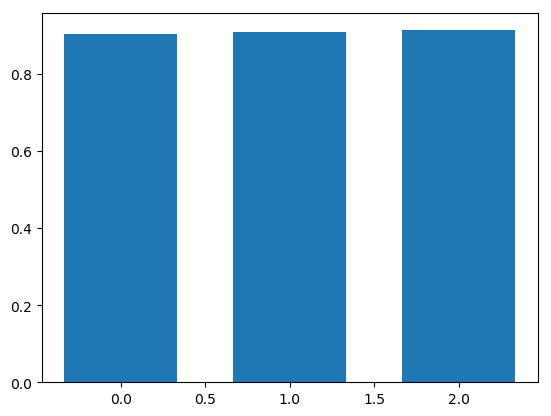

In [24]:
fig